In [ ]:
!pip install plotly

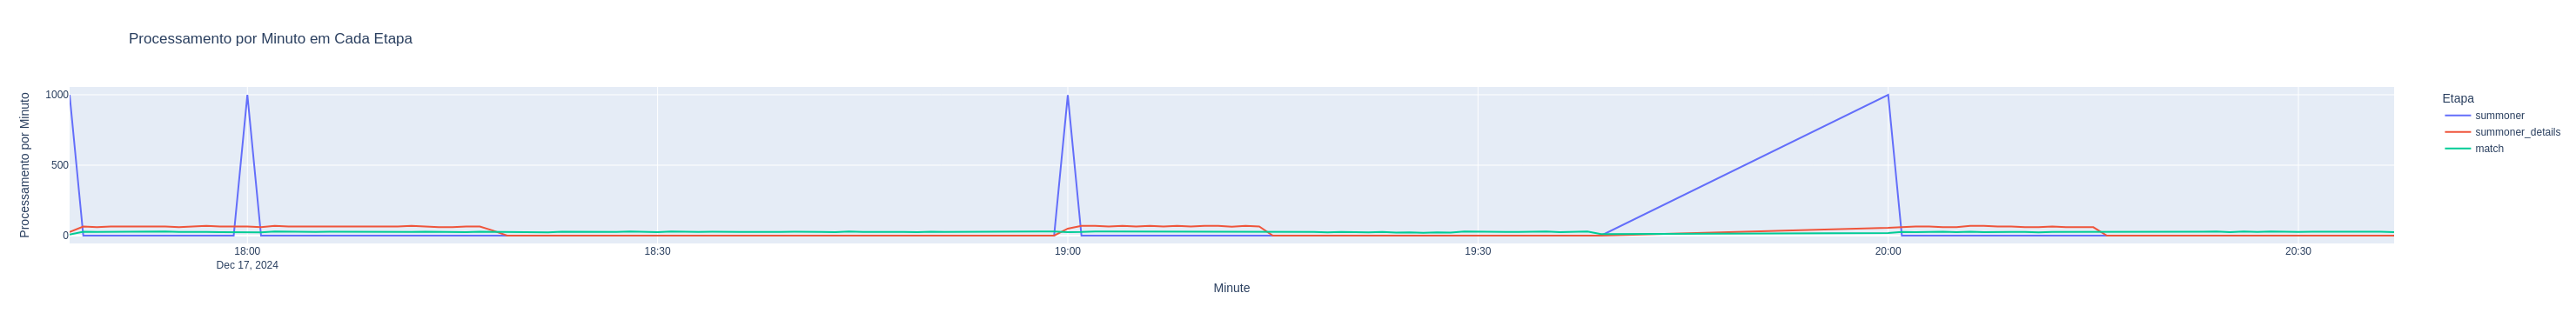

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, count
import pandas as pd
import plotly.express as px

# Inicia uma sessão Spark
spark = SparkSession.builder \
    .appName("Parquet Processing") \
    .getOrCreate()

# Substitua pelo caminho do seu arquivo Parquet
file_path = "hdfs://hadoop-namenode:8020/datalake/bronze/matchs/*/*.parquet"

# Lê o arquivo Parquet em um DataFrame
spark_df = spark.read.parquet(file_path)

# Seleciona e converte as colunas de timestamp para string formatada por minuto
# Isso permite calcular o processamento por minuto
summoner_df = spark_df.select(date_format(col("timestamp_summoner"), "yyyy-MM-dd HH:mm").alias("minute_summoner"))
details_df = spark_df.select(date_format(col("timestamp_summoner_details"), "yyyy-MM-dd HH:mm").alias("minute_details"))
match_df = spark_df.select(date_format(col("timestamp_match"), "yyyy-MM-dd HH:mm").alias("minute_match"))

# Conta o número de registros por minuto para cada etapa
summoner_counts = summoner_df.groupBy("minute_summoner").agg(count("*").alias("summoner")).toPandas()
details_counts = details_df.groupBy("minute_details").agg(count("*").alias("summoner_details")).toPandas()
match_counts = match_df.groupBy("minute_match").agg(count("*").alias("match")).toPandas()

# Renomeia as colunas para facilitar a mesclagem
summoner_counts.rename(columns={"minute_summoner": "minute"}, inplace=True)
details_counts.rename(columns={"minute_details": "minute"}, inplace=True)
match_counts.rename(columns={"minute_match": "minute"}, inplace=True)

# Mescla os resultados em um único DataFrame Pandas
combined_counts = pd.merge(summoner_counts, details_counts, on="minute", how="outer")
combined_counts = pd.merge(combined_counts, match_counts, on="minute", how="outer")

# Preenche valores nulos com zero
combined_counts.fillna(0, inplace=True)

# Converte a coluna "minute" para datetime para ordenação correta no gráfico
combined_counts["minute"] = pd.to_datetime(combined_counts["minute"])

# Ordena os dados por tempo
combined_counts.sort_values(by="minute", inplace=True)

# Gera o gráfico interativo
fig = px.line(
    combined_counts,
    x="minute",
    y=["summoner", "summoner_details", "match"],
    labels={"minute": "Minute", "value": "Processamento por Minuto", "variable": "Etapa"},
    title="Processamento por Minuto em Cada Etapa"
)

# Exibe o gráfico
fig.show()